### Implementation of the Mandelbrot Set

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cmath
from scipy.stats import qmc
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
# z_n+1 = z^2 + c
def mandelbrot(z, c):
	return add_complex(square_complex(z), c)

# (a + bi)^2 = a^2 - b^2 + 2abi
def square_complex(z):
	return complex(z.real**2 - z.imag**2, 2*z.real*z.imag)

# a+bi + c+di = a+b + (b+d)i
def add_complex(z1, z2):
	return complex(z1.real + z2.real, z1.imag + z2.imag)

# |z| = sqrt(a^2 + b^2)
def magnitude_complex(z):
	return np.sqrt(z.real**2 + z.imag**2)

In [ ]:
def mandelbrot_plot(resolution, max_length_set, re_min, re_max, im_min, im_max):
	# suggestie is om re_min, re_max, im_min en im_max optional arguments te geven. Aangezien we steeds dezelfde range gebruiken.
	real_range = np.linspace(re_min, re_max, resolution)
	imaginary_range = np.linspace(im_min, im_max, resolution)
	mat = np.full((resolution, resolution), max_length_set) # creates a matrix which will represent the mandalbrot plot

	# creates a contour plot in a horizontal direction.
	for i, im in enumerate(imaginary_range):
		for j, re in enumerate(real_range):
			c = complex(re, im)
			z = complex(0, 0)

	# checks after how many iteration the complex number diverges. if k=max_lengths_set, then no divergence.
			for k in range(max_length_set):
				z = mandelbrot(z, c)
				if magnitude_complex(z) > 2:
					mat[i, j] = k
					break

	return mat

In [31]:
mandelplot = mandelbrot_plot(resolution=2000, max_length_set=100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25)

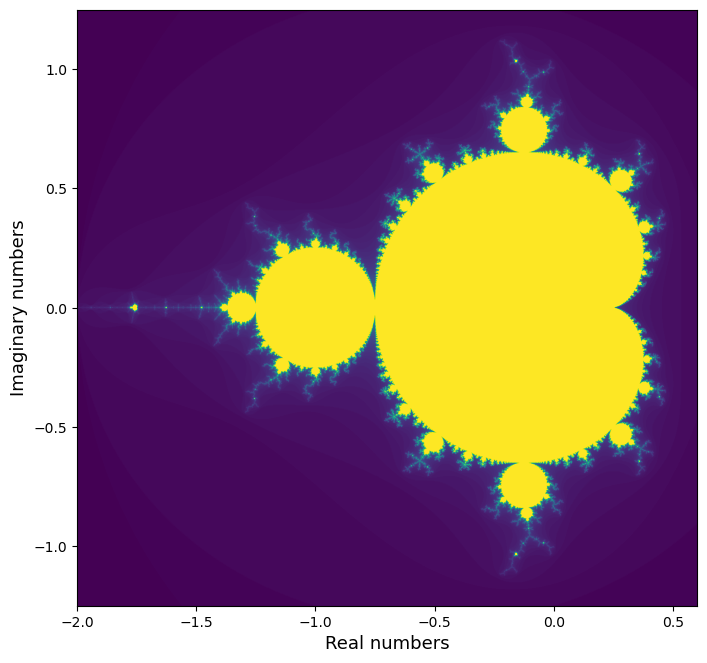

In [32]:
plt.figure(figsize=(8, 8))
plt.imshow(mandelplot, extent=[-2, 0.6, -1.25, 1.25])
plt.xlabel('Real numbers', fontsize=13)
plt.ylabel('Imaginary numbers', fontsize=13)
plt.show()

### Monte Carlo Integration

In [ ]:
# seed? if a general seed is stated at the beginning, will it influence all random generators, numpy and scipy accordingly?
def random_sampling(num_samples, re_min, re_max, im_min, im_max):
	c_re = np.random.uniform(re_min, re_max, num_samples)
	c_im = np.random.uniform(im_min, im_max, num_samples)
	c_random = c_re + 1j * c_im
	return c_random, c_re, c_im

# the seed may be unnecasry, if the prior seed is also encompensess this, but not sure
def LHC_sampling(num_samples, re_min, re_max, im_min, im_max, seed=1):
	lhc = qmc.LatinHypercube(d=2)
	samples = lhc.random(n=num_samples, seed=seed)
	scaled_samples = qmc.scale(samples, [re_min, im_min], [re_max, im_max])
	c_re = scaled_samples[:, 0]
	c_im = scaled_samples[:, 1]
	c_array = c_re + 1j * c_im
	return c_array, c_re, c_im

def orthogonal_sampling(num_samples, re_min, re_max, im_min, im_max, seed=1):
    # https://en.wikipedia.org/wiki/Orthogonal_array#Latin_hypercubes
    # https://stats.stackexchange.com/questions/41716/what-are-pure-random-sampling-and-orthogonal-sampling
    # orthogonal sampling prevents correlation and subspaces (larger than the interval chosen for the datapoint area)
    # It is like when choosing this, you expand NN clause to second order. so to spread sampling across whole space more evenly
	orth = qmc.LatinHypercube(d=2, strength=2, seed=seed)  # strength 2 makes it orthogonal sampling from what i understood
	# the p**2 constraint needs to be hendled in a way, but i am not sure how yet
	samples = orth.random(n=num_samples)  # samples must be a square of a prime number according to documentation https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.LatinHypercube.html
	scaled_samples = qmc.scale(samples, [re_min, im_min], [re_max, im_max])
	c_re = scaled_samples[:, 0]
	c_im = scaled_samples[:, 1]
	c_array = c_re + 1j * c_im
	return c_array, c_re, c_im


In [40]:
def monte_carlo(num_iterations, num_samples, max_length_set, re_min, re_max, im_min, im_max, sampling_method='random'):
	#max length set hernoemen naar convergence criterium
	# num iterations is the number of times the same number of samples is repeated for an average
	areas = np.ndarray(shape=(num_iterations, num_samples))
	# on the third dimension, the coordinates are stored in the [a,b,0] (real) and [a,b,1](imaginary) and if it is within the set, store a 1 (if not a 0) on [,,3]
	sampling = np.ndarray(shape=(num_iterations, num_samples, 3))  # on the third dimension, the coordinates are stored in the [,,0] and [,,1] and if it is within the set, store a 1 (if not a 0) on [,,3]
	area_integration_box = np.abs(re_max-re_min) * np.abs(im_max-im_min)   # suggestion np. abs after the product is sufficient

	for i in range(num_iterations):
		# Choose sampling method for integration
		if sampling_method == 'random':
			c_array, c_re, c_im = random_sampling(num_samples, re_min, re_max, im_min, im_max)
		elif sampling_method == 'LHS':
			c_array, c_re, c_im = LHC_sampling(num_samples, re_min, re_max, im_min, im_max)
		elif sampling_method == 'OS':
			c_array, c_re, c_im = orthogonal_sampling()
		else:
			raise ValueError("This is not a valid sampling method. Choose 'random', 'LHS', or 'OS'.")

		points_outside = 0
		for j in range(num_samples):
			z = complex(0,0)

			for k in range(max_length_set):
				z = mandelbrot(z, c_array[j])
				if magnitude_complex(z) > 2:
					sampling[i, j, :] = c_re[j], c_im[j], 0
					points_outside += 1
					break

				sampling[i, j, :] = c_re[j], c_im[j], 1

			areas[i,j] = area_integration_box * (1-(points_outside/(j+1)))

	return areas, sampling


In [41]:
area_mc_sampling = monte_carlo(1, 100000, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHS')
_, samples = area_mc_sampling

In [42]:
# Take a single sample from Monte Carlo
sample = samples[0]  #? does this not rather give a single iteration or is it ignored due to it being 1?
x0, y0 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 1, :2] ]) #suggestion x0 = mc_in_area_x etc.
x1, y1 = zip(*[ [x, y] for x, y in sample[sample[:, 2] == 0, :2] ]) #suggestion x1 = mc_out_area_x etc.

In [43]:
num_samples = 1000
num_iter = 200
area_mc,_ = monte_carlo(num_iter, num_samples, 100, re_min=-2, re_max=0.6, im_min=-1.25, im_max=1.25, sampling_method='LHS')
duration = range(num_samples)  # duration to sample_size_mc, but also why a seperate variable

In [44]:
print(f'Area at {num_samples} samples = {np.mean(area_mc[:,num_samples-1])}')

Area at 1000 samples = 1.5432625


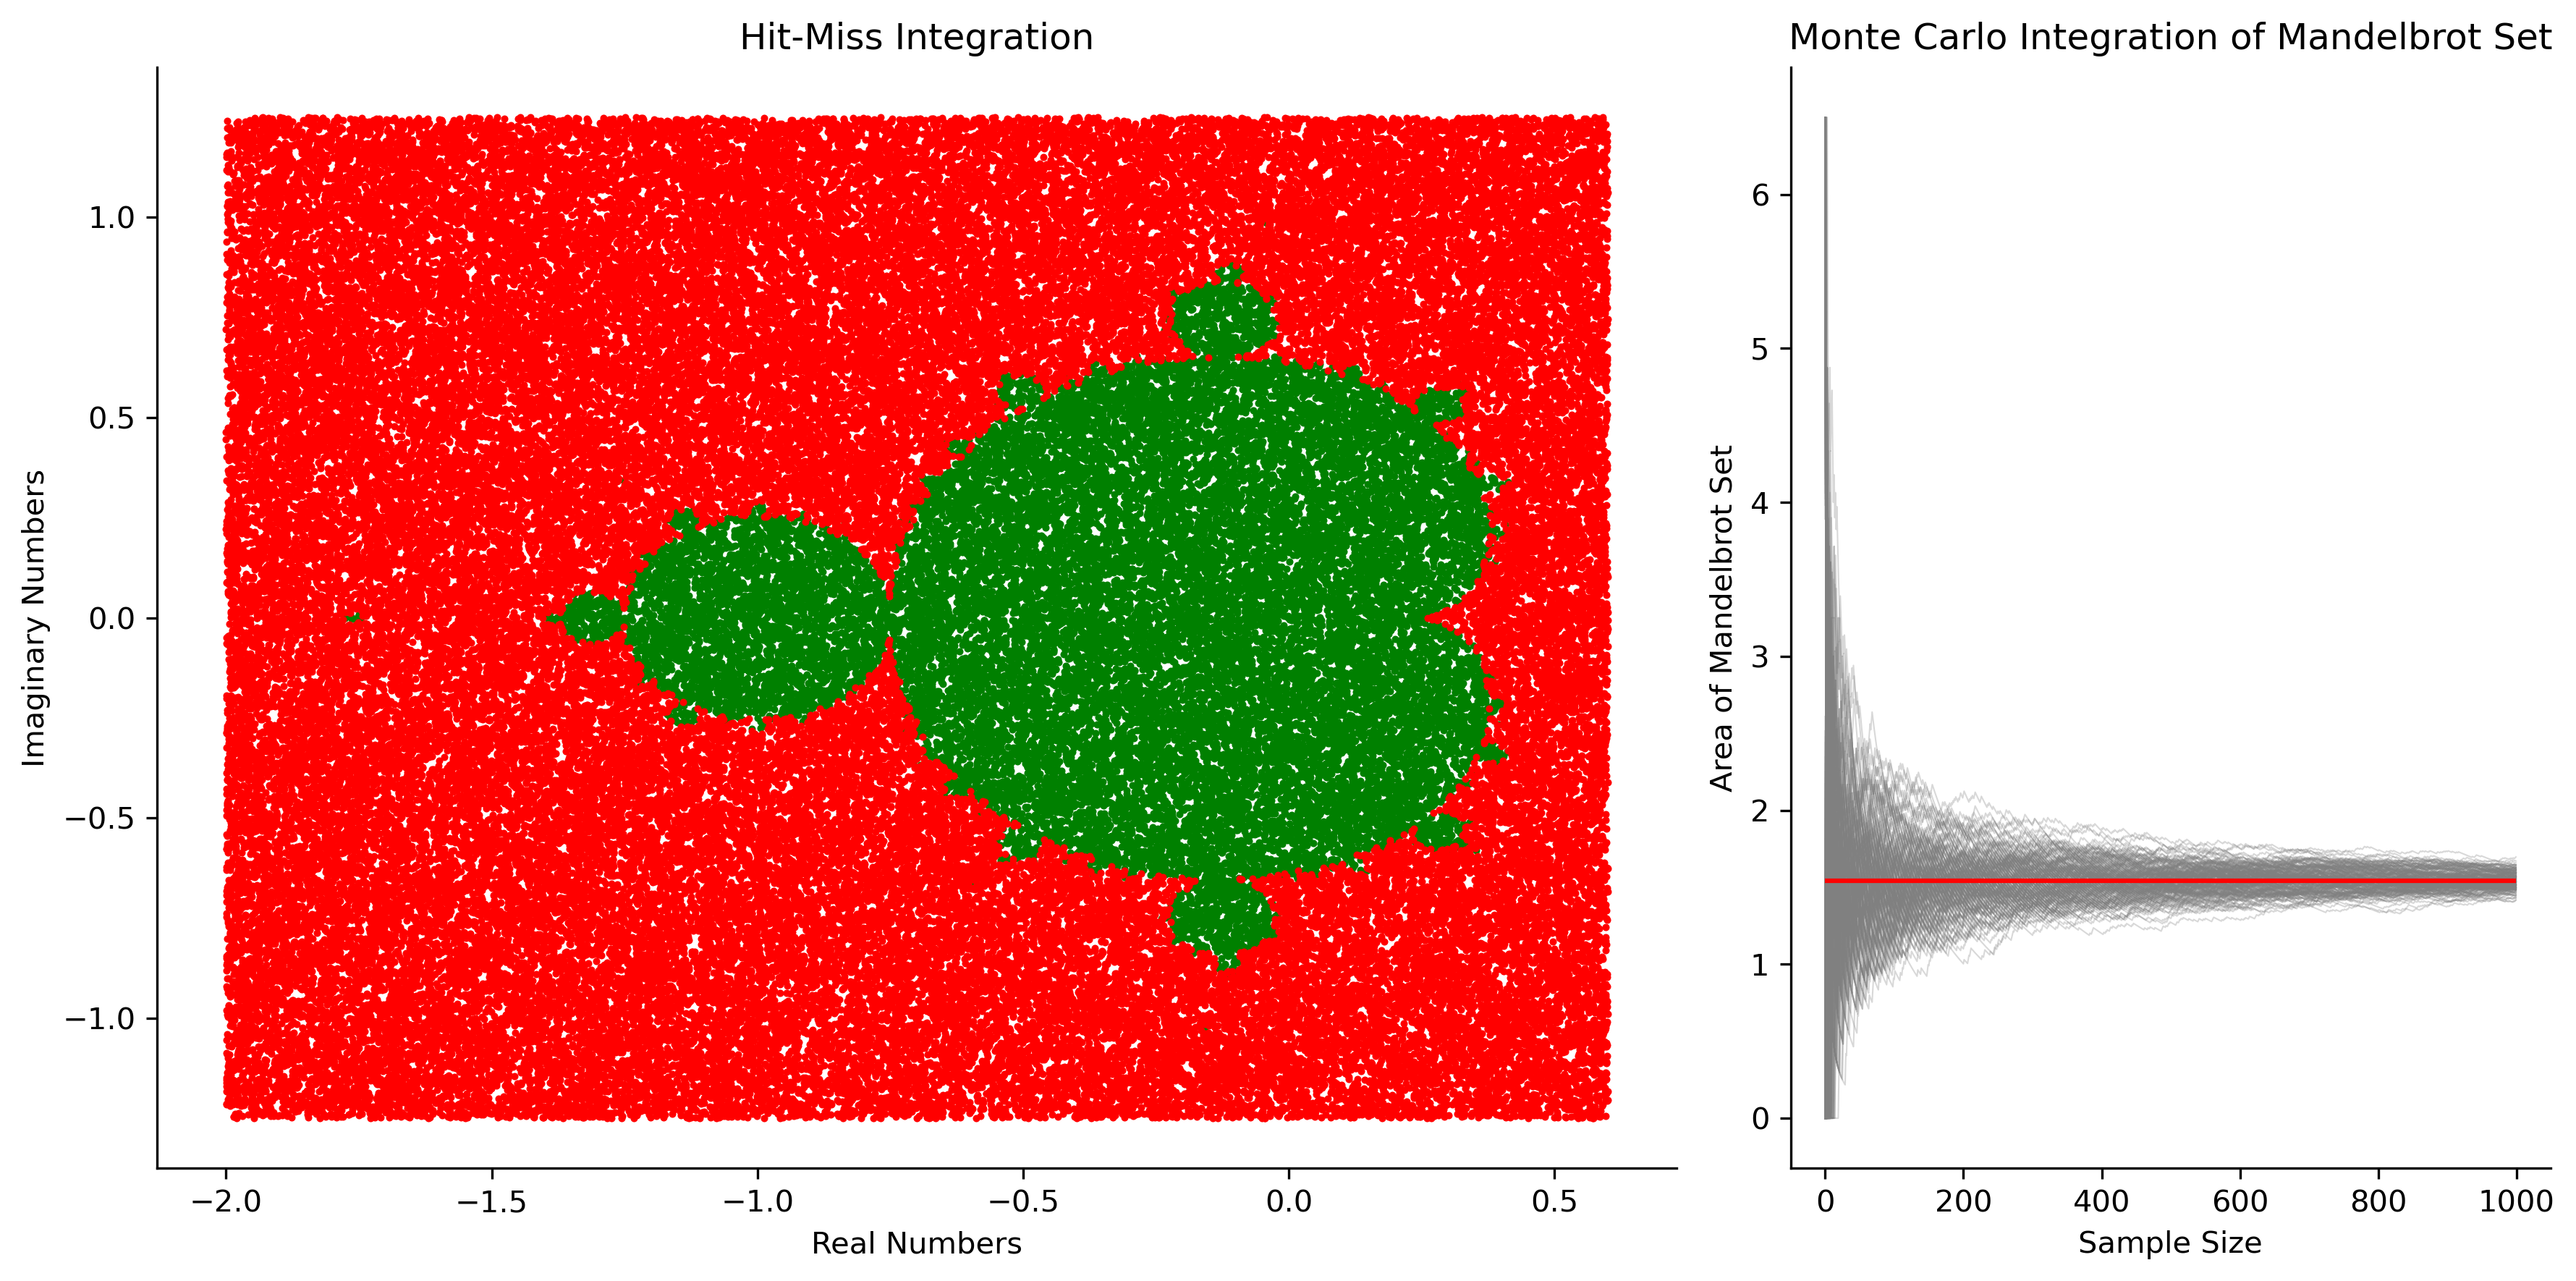

In [45]:
# Create a figure and use GridSpec to control the plot size ratios
fig = plt.figure(figsize=(12, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[2, 1], figure=fig)  # Set width ratio to make second plot smaller

# Subplot 1: Line plot for infection peak reduction
ax1 = fig.add_subplot(gs[0])


ax1.scatter(x = x0, y= y0, color = 'green', s=2)
ax1.scatter(x = x1, y= y1, color = 'red', s=2)

ax1.set_title('Hit-Miss Integration', fontsize=12) #idk of hit-miss de passende naam is? dat nog uitzoeken of zeg mc area simulation mandelbrot
ax1.set_xlabel('Real Numbers')  # real axis
ax1.set_ylabel('Imaginary Numbers') # imaginary axis

ax2 = fig.add_subplot(gs[1])
for i in range(num_iter):
	ax2.plot(duration, area_mc[i], alpha=0.3, color = 'grey', lw =0.5)
#ax2.clabel(contours, inline=True, fontsize=8)
ax2.hlines(np.mean(area_mc[:,num_samples-1]), xmin=0, xmax=num_samples-1, color = 'red') #mby de echte opzoeken op het internet)

ax2.set_ylabel("Area of Mandelbrot Set")
ax2.set_xlabel("Sample Size")
ax2.set_title("Monte Carlo Integration of Mandelbrot Set")


# Remove unnecessary spines from both subplots
#? what is a spine?
#ans: Spines are the black lines at the top and right of the plot. It has nothing to do with the simulations. Its visually different ~ Job
for ax in [ax1, ax2]:
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure with high resolution (300 DPI)
plt.savefig('combined_plot_with_labels.png', dpi=300)
plt.show()


### Variability as a function of Iterations and Samples

In [3]:
num_samples_values = np.logspace(1, 3, 10).astype(int)
num_iterations_values =  np.logspace(1, 3, 10).astype(int)

# Set up grid to store standard deviations
std_dev_grid = np.zeros((len(num_iterations_values), len(num_samples_values)))

std_dev_grid

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# Run Monte Carlo simulations for each combination of num_iterations and num_samples
for i, num_iterations in enumerate(num_iterations_values):
	for j, num_samples in enumerate(num_samples_values):
		# Perform the Monte Carlo simulation
		areas, _ = monte_carlo(num_iterations, num_samples, max_length_set=100, re_min=-2, re_max=2, im_min=-2, im_max=2)

		# Calculate standard deviation of areas for the current parameters
		std_dev_grid[i, j] = np.std(areas)

In [13]:
std_dev_grid

array([[1.50646844, 2.27292893, 1.78939901, 1.56915265, 0.98445757,
        0.94459979, 0.84554676, 0.70547179, 0.33650185, 0.43805667],
       [2.43211035, 1.95733851, 2.12908988, 1.6856157 , 1.38806113,
        0.89046618, 0.78783813, 0.75580039, 0.5294679 , 0.36372741],
       [2.24975813, 2.17926864, 2.06836524, 1.574691  , 1.12871527,
        0.94176584, 0.76256075, 0.6150968 , 0.43869765, 0.40744536],
       [2.86900119, 2.05636319, 2.12699985, 1.4142903 , 1.32511561,
        0.90785264, 0.80130797, 0.715266  , 0.58661435, 0.41507042],
       [2.81574344, 2.30088165, 1.7330008 , 1.41041168, 1.06645236,
        1.02404657, 0.7414576 , 0.65030199, 0.50096339, 0.43010046],
       [2.63721267, 1.87286089, 1.86124635, 1.41002778, 1.15332365,
        0.92565677, 0.79614502, 0.65432509, 0.49330583, 0.41481398],
       [2.93457371, 2.23618096, 1.71624289, 1.33516517, 1.24310467,
        0.97049511, 0.80674936, 0.61369077, 0.49287276, 0.39930977],
       [2.47356799, 2.25770833, 1.8396778

In [5]:
X, Y = np.meshgrid(num_samples_values, num_iterations_values)

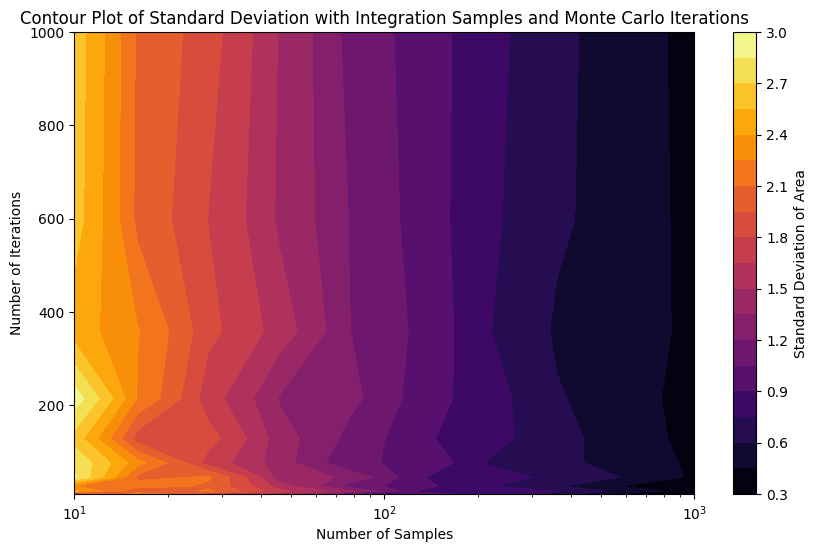

In [15]:
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, std_dev_grid, levels=20, cmap='inferno')
plt.colorbar(contour, label='Standard Deviation of Area')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Iterations')
plt.xscale('log')
#plt.yscale('log')
plt.title('Contour Plot of Standard Deviation with Integration Samples and Monte Carlo Iterations')
plt.show()

if we want to apply p=0.05, we can calculate sqrt n and sigma beforehand to , look into slides for how we can find std if we set n